In [1]:
import torch
try:
    import torch_geometric
    print("Entorno ya está configurado correctamente.")
except ImportError:
    print("Reinstalando dependencias compatibles con torch", torch.__version__)
    # Eliminar versiones anteriores conflictivas
    !pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-cluster torch-geometric torch-spline-conv -q

    # Instalar PyTorch con CUDA 11.8
    !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

    # Instalar dependencias específicas de PyTorch Geometric para torch 2.0.1 + CUDA 11.8
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    !pip install torch-geometric

    # Otras librerías útiles
    !pip install matplotlib pandas
    !pip install numpy==1.24.4

Reinstalando dependencias compatibles con torch 2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 581.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89990 sha256=3c8dce7566b225092bd30e477dbbdc546597a006724f32f4c52eb1e3bee6f217
  Stored in directory: /root/.cache/pip/wheels/fc/5d/45/34fe9945d5e45e261134e72284395be36c2d4828af38e2b0fe
Successfully built lit
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 102.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver

In [1]:
# Eliminar carpeta antigua si existe, para evitar que se quede en  el caché
!rm -rf ia_thermal

# Clonar versión actualizada desde GitHub
!git clone https://github.com/ismaelgallolopez/ia_thermal.git

%cd ia_thermal/ernestoemedina/GCN_MK1

Cloning into 'ia_thermal'...
remote: Enumerating objects: 6009, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 6009 (delta 62), reused 70 (delta 42), pack-reused 5914 (from 2)
Receiving objects: 100% (6009/6009), 338.82 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (1003/1003), done.
Updating files: 100% (4072/4072), done.
/content/ia_thermal/ernestoemedina/GCN_MK1


In [2]:
# Añadir ruta al sistema para importar módulos locales
import sys
sys.path.append('/content/ia_thermal/ernestoemedina/GCN_MK1')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

dir_path = "/content/drive/MyDrive/ErnestoData"



2.0.1+cu118
CUDA disponible: True


# Librerías

In [5]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import sys
import time
import platform
import random
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from gcn_model import GCN
from torch_geometric.loader import DataLoader
from dataset_utils import generate_edge_index, build_graph_list, build_graph_from_sample
from train_eval import train, evaluate, EarlyStopping

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
# Propiedades del sistema
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda
    print("system_specs", system_specs)


system_specs {'os': 'Linux', 'os_version': '#1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025', 'machine': 'x86_64', 'processor': 'x86_64', 'python_version': '3.11.12', 'device': 'cuda', 'gpu_name': 'Tesla T4', 'gpu_memory_total_GB': 14.74, 'cuda_version': '11.8'}


In [8]:
#dir_path = os.getcwd()
print(dir_path)

/content/drive/MyDrive/ErnestoData


In [9]:
# Ruta del dataset completo
dataset_path = os.path.join(dir_path, "Datasets", "PCB_dataset.pth")
norm_dataset_path = os.path.join(dir_path, "Datasets", "PCB_Dataset_Norm.pth")

# Cargar dataset
dataset = torch.load(dataset_path)
norm_dataset = torch.load(norm_dataset_path)

## Para desnormalizar

In [10]:
# Cargar la info de normalización
info_path = os.path.join(dir_path, "Datasets", "normalization_info.pth")
norm_info = torch.load(info_path)

max_T_interfaces = norm_info["max_T_interfaces"]
max_Q_heaters = norm_info["max_Q_heaters"]
max_T_env = norm_info["max_T_env"]

## En ppio no debería ser necesario, ya que hemos cargado el dataset sin normalizar

def desnormalize_inputs(dataset_norm, idx):
    T_interfaces_norm = dataset_norm.T_interfaces[idx]
    Q_heaters_norm = dataset_norm.Q_heaters[idx]
    T_env_norm = dataset_norm.T_env[idx]

    T_interfaces_real = T_interfaces_norm * max_T_interfaces
    Q_heaters_real = Q_heaters_norm * max_Q_heaters
    T_env_real = T_env_norm * max_T_env

    return T_interfaces_real, Q_heaters_real, T_env_real

In [11]:
idx = 1
T_interfaces_real, Q_heaters_real, T_env_real = desnormalize_inputs(norm_dataset, idx)

# Por ejemplo:
print(torch.max(T_interfaces_real), "K")
print(torch.max(Q_heaters_real), "W")
print(torch.max(T_env_real), "K")


tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [12]:
# Seleccionar un índice para graficar
idx = 1  # Puedes cambiar este valor

# Obtener los valores reales de las CC en T, Q y T_env
T_interfaces_real = dataset.denormalize_T_interfaces(dataset.T_interfaces)
Q_heaters_real = dataset.denormalize_Q_heaters(dataset.Q_heaters)
T_env_real = dataset.denormalize_T_env(dataset.T_env)

print(T_interfaces_real.shape)
print(torch.max(T_interfaces_real[idx]), "K")
print(torch.max(Q_heaters_real[idx]), "W")
print(torch.max(T_env_real[idx]), "K")


torch.Size([10000, 13, 13])
tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [13]:
idx = 10
T_interfaces_norm = norm_dataset.T_interfaces[idx]
Q_heaters_norm = norm_dataset.Q_heaters[idx]
T_env_norm = norm_dataset.T_env[idx]

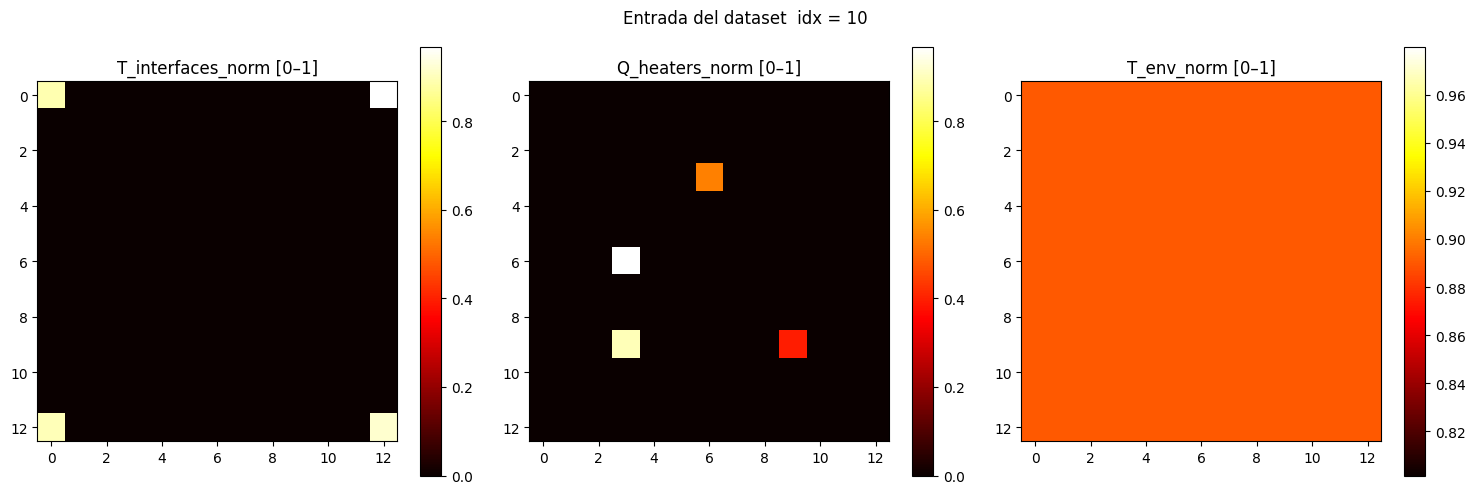

In [14]:
# Crear figura para mostrar las 3 variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = axs[0].imshow(T_interfaces_norm.numpy(), cmap='hot')
axs[0].set_title("T_interfaces_norm [0–1]")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(Q_heaters_norm.numpy(), cmap='hot')
axs[1].set_title("Q_heaters_norm [0–1]")
plt.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(T_env_norm.numpy(), cmap='hot')
axs[2].set_title("T_env_norm [0–1]")
plt.colorbar(im3, ax=axs[2])

plt.suptitle(f"Entrada del dataset  idx = {idx}")
plt.tight_layout()
plt.show()

## GCN

### Configuración de la red

In [15]:
# Configuración del modelo
config = {
    "input_dim": 3,           # 3 canales: T_interfaces, Q_heaters, T_env
    "hidden_dim": 256,
    "output_dim": 1,
    "num_layers": 3,
    "use_dropout": True,
    "dropout_rate": 0.15217808088248522,
    "use_batchnorm": True,
    "use_residual": False,
    "batch_size": 16,
    "lr": 0.0022165075808203588,
    "max_epochs": 10000,
    "early_stop_patience": 100,
    "error_threshold_K": 3.0,
    "use_percentage_threshold": False,
    "percentage_threshold": 1.0,  # solo si se activa la opción
    "save_model": False,
    "load_model": False, # Cargar un modelo preentrenado
    "factor" : 0.5 , # Factor de reducción del learning rate
    "patience" : 10 , # Épocas sin mejora para reducir el learning rate
    "min_lr" : 1e-9,  # evita que baje infinitamente el learning rate
    "use_physics" : False,
    "lambda_physics" : 0.0001, # Peso de la física en la función de pérdida
    "use_boundary_loss" : False,
    "lambda_boundary" : 0.01,
    "use_heater_loss" : False,
    "lambda_heater" : 0.01
}

In [16]:
grid_size = norm_dataset.inputs.shape[-1]
print("PCB cuadrada de", grid_size, "nodos por lado")
edge_index = generate_edge_index(grid_size=grid_size) # Matriz de adyacencia bidireccional
graphs = build_graph_list(norm_dataset, edge_index)

PCB cuadrada de 13 nodos por lado


In [17]:
# Por si en algún momento el Dataset tuviera un patrón al ser generado
random.seed(42)
random.shuffle(graphs)

In [18]:

# Ruta al dataset normalizado

# Extraer un tensor de salida
sample_output = norm_dataset.outputs[0]

# Imprimir estadísticas globales de outputs
all_outputs = norm_dataset.outputs.view(-1)
print(f"Mean of outputs: {all_outputs.mean().item():.4f}")
print(f"Std of outputs:  {all_outputs.std().item():.4f}")

# También desde los atributos si están disponibles
if hasattr(norm_dataset, "T_outputs_mean"):
    print(f"Atributo .T_outputs_mean: {norm_dataset.T_outputs_mean.item():.4f}")
    print(f"Atributo .T_outputs_std:  {norm_dataset.T_outputs_std.item():.4f}")


Mean of outputs: 0.8303
Std of outputs:  0.0338
Atributo .T_outputs_mean: 0.0000
Atributo .T_outputs_std:  1.0000


### División Dataset

In [19]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',            # queremos minimizar el val_loss
    factor=config["factor"],            # reduce a la mitad el LR
    patience=config["patience"],           # espera 10 épocas sin mejora
    verbose=True,          # imprime info cuando reduce
    min_lr=config["min_lr"]            # evita que baje infinitamente
)


In [21]:
print("Forma de entrada:", norm_dataset.inputs[0].shape)
print("Forma de salida:", norm_dataset.outputs[0].shape)


Forma de entrada: torch.Size([3, 13, 13])
Forma de salida: torch.Size([13, 13])


### Entrenamiento

In [22]:
# Entrenamiento
train_losses = []
val_losses = []

early_stopper = EarlyStopping(patience=config["early_stop_patience"])
max_epochs = config["max_epochs"]

print("Iniciando entrenamiento...")
for epoch in range(config["max_epochs"]):
    # Entrenar
    train_loss = train(model, train_loader, optimizer, device, lambda_physics=config["lambda_physics"],
                       use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
                       use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
                       use_heater_loss=config["use_heater_loss"])
    train_losses.append(train_loss)

    # Evaluar en validación
    val_mse, val_mae, val_r2, val_accuracy, val_physics, val_boundary, val_heaters = evaluate(
        model, val_loader, device, use_physics=config["use_physics"],use_boundary_loss=config["use_boundary_loss"],
        use_heater_loss=config["use_heater_loss"],
        error_threshold=config["error_threshold_K"],
        percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
        plot_results=False
    )
    val_losses.append(val_mse)

    scheduler.step(val_mse)

    # Formatear bien los losses opcionales
    physics_loss_str = f"{val_physics:.6f}" if val_physics is not None else "N/A"
    boundary_loss_str = f"{val_boundary:.6f}" if val_boundary is not None else "N/A"
    heaters_loss_str = f"{val_heaters:.6f}" if val_heaters is not None else "N/A"

    # Imprimir métricas
    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {train_loss:.6f} | "
          f"Val MSE: {val_mse:.6f} | "
          f"Val MAE: {val_mae:.6f} | "
          f"Val R²: {val_r2:.4f} | "
          f"[Boundary loss] {boundary_loss_str} | "
          f"[Heaters loss] {heaters_loss_str} | "
          f"[Physics loss] {physics_loss_str} | "
          f"Val Accuracy: {val_accuracy:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.9f}")

    # Guardar el mejor modelo en memoria
    if val_mse < early_stopper.best_loss:
        best_model_state = model.state_dict()
        final_epoch = epoch + 1

    early_stopper(val_mse, epoch)
    if early_stopper.early_stop:
        print(f" Early stopping triggered at epoch {epoch}")
        break


Iniciando entrenamiento...


FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/normalization_info.pth'

In [ ]:
# Cargar el mejor modelo antes de guardar
if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("⚠️ Advertencia: No se ha encontrado un modelo mejor durante el entrenamiento.")

# Crear nombre de archivo con los hiperparámetros clave
model_name = (
    f"GCN_Layers_{config['num_layers']}_"
    f"HDim_{config['hidden_dim']}_"
    f"Epochs_{final_epoch}_"
    f"Lr_{config['lr']}_"
    f"B_LOSS_{config['use_boundary_loss']}_"
    f"Lambda_{config['lambda_boundary']}_"
    f"H_LOSS_{config['use_heater_loss']}_"
    f"Lambda_{config['lambda_heater']}_"
    f"PI_{config['use_physics']}_"
    f"Lambda_{config['lambda_physics']}_"
    f"Batch_{config['batch_size']}.pth"
)
print("Nombre del modelo:", model_name)

In [ ]:
# GRAFICAR MSE
# Crear carpeta si no existe
os.makedirs("LOSS_IMG", exist_ok=True)
loss_img_filename = model_name.replace(".pth", ".svg")
loss_img_path = os.path.join("LOSS_IMG", loss_img_filename)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss (MSE)', linewidth=2)

# Escala logarítmica en y (opcional)
plt.yscale("log")

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Evolución del Loss por Época')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Eje X con enteros
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(loss_img_path, format="svg")
plt.show()

### Carga de modelos ya entrenados

In [ ]:
if config["load_model"]:
    from dataset_utils import load_model_by_name

    # Definir el modelo a cargar, los modelos guardados no guardan la arquitectura de la red
    model = GCN(
        input_dim=config["input_dim"],
        hidden_dim= 64,
        output_dim=config["output_dim"],
        num_layers= 10,
        use_dropout=config["use_dropout"],
        dropout_rate=config["dropout_rate"],
        use_batchnorm=config["use_batchnorm"],
        use_residual=config["use_residual"]
    ).to(device)

    # Nombre exacto del archivo que quieres cargar, cambiar solo los números
    model_filename = "GCN_Layers_10_HDim_64_Epochs_1000_Lr_0.001_Batch_32.pth"

    # Cargar modelo concreto
    model = load_model_by_name(model, model_filename)
    print("Modelo cargado:", model_filename)


### Evaluación

In [ ]:
# Evaluar en test y graficar un ejemplo
print("Evaluando en test set con visualización de un ejemplo:")
test_mse, test_mae, test_r2, test_accuracy, test_physics, test_boundary, test_heater = evaluate(
    model, test_loader, device, use_physics=config["use_physics"],
    error_threshold=config["error_threshold_K"],
    percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
    plot_results=True
)

physics_loss_str = f"{test_physics:.6f}" if test_physics is not None else "N/A"

print("Resultados del test:")
print(f"MSE       : {test_mse:.6f}")
print(f"MAE       : {test_mae:.6f}")
print(f"R²        : {test_r2:.4f}")
print(f"Accuracy  : {test_accuracy:.2f}%")
print(f"Boundary Loss  : {test_boundary:.6f}")
print(f"Heaters Loss  : {test_heater:.6f}")
print(f"Physics Loss  : {physics_loss_str}")

### GNNExplainer

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

# Poner el modelo en modo evaluación
model.eval()

# Crear el explainer solo una vez
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    edge_mask_type='object',
    node_mask_type='attributes',
    model_config=ModelConfig(
        mode='regression',
        task_level='node',
        return_type='raw'
    )
)

# ---------------- CONFIGURACIÓN ----------------
graph_idx = 3      # <- Cambia este valor para elegir el grafo del test set
node_idx = 69     # <- Cambia este valor para elegir el nodo a explicar
# ------------------------------------------------

# Obtener el grafo y pasarlo a GPU si es necesario
graph = test_dataset[graph_idx].to(device)

# Predecir con el modelo
with torch.no_grad():
    pred = model(graph.x, graph.edge_index).squeeze()
true = graph.y.squeeze()
error = torch.abs(pred - true)

# Obtener explicación
explanation = explainer(
    x=graph.x,
    edge_index=graph.edge_index,
    index=node_idx
)

# Obtener importancia del explainer y agrupar por nodo
importance = explanation.node_mask.squeeze().cpu()      # Así obtenemos las features por nodo
importance = importance.view(-1, 3)                     # Cambiamos a un tensor que pueda ser interpretado como [num_nodes, num_features]
importance_per_node = importance.mean(dim=1)            # [num_nodes] Hacemos la media de la importancia de las 3 características en la predicción

# Obtener tamaño cuadrícula real del dataset
num_nodes = graph.y.numel()
print("Número de nodos:", num_nodes)
grid_size = int(num_nodes ** 0.5)
assert grid_size ** 2 == num_nodes, f"El número de nodos ({num_nodes}) no coincide con cuadrícula {grid_size}x{grid_size}"

# Convertir vectores a cuadrícula
importance_grid = importance_per_node.view(grid_size, grid_size)
error_grid = error.view(grid_size, grid_size).cpu()

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im1 = axs[0].imshow(importance_grid, cmap='hot')
# Coordenadas del nodo que estás explicando
row = node_idx // grid_size
col = node_idx % grid_size

# Dibujar un punto rojo en la celda correspondiente
axs[0].plot(col, row, 'o', markersize=10, markeredgecolor='black', markerfacecolor='cyan', label='Nodo explicado')
axs[0].legend(loc='upper right')

axs[0].set_title(f"Importancia (nodo {node_idx})")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(error_grid, cmap='Blues')
# Número de nodos a etiquetar
top_n = 5  # "n" nodos de mayor error a mostrar

# Obtener los índices de los nodos con mayor error
top_error_nodes = torch.topk(error, top_n).indices.cpu()

for idx in top_error_nodes:
    idx = idx.item()
    row = idx // grid_size
    col = idx % grid_size
    axs[1].text(
        col, row, str(idx),
        ha='center', va='center',
        fontsize=8, fontweight='bold',
        color='black', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7)
    )
axs[1].set_title("Error absoluto por nodo")
plt.colorbar(im2, ax=axs[1])

plt.suptitle(f"Grafo {graph_idx} | Nodo {node_idx} explicado")
plt.tight_layout()
plt.show()

### Guardado del modelo ya entrenado

In [ ]:
# Crear carpeta si no existe
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Guardar el modelo
model_path = os.path.join(save_dir, model_name)
if config["save_model"]:
    # Guardar el modelo entrenado
    torch.save(model.state_dict(), model_path)

    print(f" Modelo guardado en: {model_path}")

### Predicción

In [ ]:

fr train_eval import predict
from dataset_utils import load_latest_model
# Cargar el modelo más reciente
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
)

model = load_latest_model(model)

# Predecir sobre test
predicciones = predict(model, test_loader)

print("Predicciones shape:", predicciones.shape)